<a href="https://colab.research.google.com/github/bombaybrew/colab_experiments/blob/master/quickdraw_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

REFERENCE:

https://colab.research.google.com/github/zaidalyafeai/zaidalyafeai.github.io/blob/master/sketcher/Sketcher.ipynb
https://github.com/googlecreativelab/quickdraw-dataset

In [2]:
# !gcloud auth login
# !gcloud config set project 'upheld-quanta-284618'

In [3]:
!gsutil cp gs://ml_workspace/quick_draw/ds_20k.zip data.zip

Copying gs://ml_workspace/quick_draw/ds_20k.zip...
- [1 files][614.1 MiB/614.1 MiB]   23.5 MiB/s                                   
Operation completed over 1 objects/614.1 MiB.                                    


In [4]:
# !ls -lah
# !mkdir data
# !unzip data.zip
# !rm data.zip

total 615M
drwxr-xr-x 1 root root 4.0K Aug 15 08:56 .
drwxr-xr-x 1 root root 4.0K Aug 15 08:54 ..
drwxr-xr-x 1 root root 4.0K Aug 15 08:55 .config
-rw-r--r-- 1 root root 615M Aug 15 08:56 data.zip
drwxr-xr-x 1 root root 4.0K Jul 30 16:30 sample_data
Archive:  data.zip
  inflating: data/carrot.npy         
  inflating: data/crab.npy           
  inflating: data/kangaroo.npy       
  inflating: data/guitar.npy         
  inflating: data/eye.npy            
  inflating: data/chair.npy          
  inflating: data/shark.npy          
  inflating: data/ant.npy            
  inflating: data/bird.npy           
  inflating: data/bucket.npy         
  inflating: data/frog.npy           
  inflating: data/cactus.npy         
  inflating: data/computer.npy       
  inflating: data/toothbrush.npy     
  inflating: data/house.npy          
  inflating: data/beach.npy          
  inflating: data/stairs.npy         
  inflating: data/circle.npy         
  inflating: data/hand.npy           
  inflati

In [5]:
# IMPORTS

import os
import glob
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
import gc

from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [6]:
def load_data(vfold_ratio=0.2, max_items_per_class= 5000):

  files = glob.iglob("data/*.npy")

  print('load_data','init variables', files)
  #initialize variables 
  x = np.empty([0, 784])
  y = np.empty([0])
  class_names = []

  #load each data file 
  for idx, file in enumerate(files):
    print('load_data','file - ', file)
    data = np.load(file)
    data = data[0: max_items_per_class, :]
    labels = np.full(data.shape[0], idx)

    x = np.concatenate((x, data), axis=0)
    y = np.append(y, labels)

    class_name, ext = os.path.splitext(os.path.basename(file))
    class_names.append(class_name)

  data = None
  labels = None

  gc.collect()

  print('load_data','randomizing dataset')
  #randomize the dataset 
  permutation = np.random.permutation(y.shape[0])
  x = x[permutation, :]
  y = y[permutation]

  print('load_data','generating test / train') 
  #separate into training and testing 
  vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

  x_test = x[0:vfold_size, :]
  y_test = y[0:vfold_size]

  x_train = x[vfold_size:x.shape[0], :]
  y_train = y[vfold_size:y.shape[0]]
  return x_train, y_train, x_test, y_test, class_names

In [7]:
x_train, y_train, x_test, y_test, class_names = load_data(0.2, 7500)

load_data init variables <generator object _iglob at 0x7fe98abd1eb8>
load_data file -  data/eye.npy
load_data file -  data/dragon.npy
load_data file -  data/circle.npy
load_data file -  data/garden.npy
load_data file -  data/cake.npy
load_data file -  data/fan.npy
load_data file -  data/guitar.npy
load_data file -  data/sun.npy
load_data file -  data/stove.npy
load_data file -  data/monkey.npy
load_data file -  data/banana.npy
load_data file -  data/kangaroo.npy
load_data file -  data/frog.npy
load_data file -  data/fish.npy
load_data file -  data/nail.npy
load_data file -  data/mouse.npy
load_data file -  data/bee.npy
load_data file -  data/hammer.npy
load_data file -  data/stairs.npy
load_data file -  data/peanut.npy
load_data file -  data/spider.npy
load_data file -  data/chair.npy
load_data file -  data/cup.npy
load_data file -  data/grapes.npy
load_data file -  data/laptop.npy
load_data file -  data/pig.npy
load_data file -  data/pizza.npy
load_data file -  data/baseball.npy
load_

In [8]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print("-----------")
print(x_train[0].shape)
print(x_train.nbytes/1024/1024)

(720000, 784)
(720000,)
(180000, 784)
(180000,)
-----------
(784,)
4306.640625


In [ ]:
from random import randint
def visualise_random(x, y):

  idx = randint(0, len(x))
  plt.imshow(x[idx].reshape(28,28))
  print(class_names[int(y[idx])])

finger


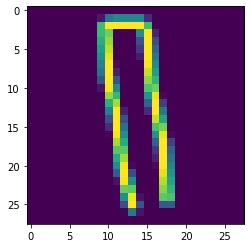

In [ ]:
visualise_random(x_train, y_train)

In [9]:
# Pre-Processing
image_size = 28

# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float16')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float16')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, len(class_names))
y_test = keras.utils.to_categorical(y_test, len(class_names))

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print("-----------")
print(x_train[0].shape)
print(x_train.nbytes/1024/1024)

(720000, 28, 28, 1)
(720000, 120)
(180000, 28, 28, 1)
(180000, 120)
-----------
(28, 28, 1)
1076.66015625


In [ ]:
# print(x_train[0])

In [ ]:
x_train.shape[1:]

(28, 28, 1)

In [18]:
import tensorflow as tf
from sklearn import metrics

experiment = Experiment(auto_weight_logging=True)
experiment.set_name('adam_default_7_3c_2d')

# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),padding='same', input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(24, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='tanh'))
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(len(class_names), activation='softmax')) 
# Train model
adam = tf.keras.optimizers.Adam()
sgd = tf.keras.optimizers.SGD()
model.compile(loss='categorical_crossentropy',optimizer=adam,
              metrics=['accuracy'])
print(model.summary())

def print_metric(model):

  score = model.evaluate(x_test, y_test, verbose=1)
  print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))
  print('----------')

  y_pred = model.predict(x_test, verbose=2)
  # y_pred = (y_pred > 0.5 ? 1 : 0)
  y_pred_argmax = np.argmax(y_pred, axis=1)
  y_test_argmax = np.argmax(y_test, axis=1)
  print(metrics.classification_report(y_test_argmax, y_pred_argmax))
  print('----------')
  print('HammingLoss: ', metrics.hamming_loss(y_test_argmax, y_pred_argmax))

NameError: ignored

In [13]:
from keras.callbacks import EarlyStopping
def print_metric(model):

  score = model.evaluate(x_test, y_test, verbose=1)
  print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))
  print('----------')

  y_pred = model.predict(x_test, verbose=2)
  # y_pred = (y_pred > 0.5 ? 1 : 0)
  y_pred_argmax = np.argmax(y_pred, axis=1)
  y_test_argmax = np.argmax(y_test, axis=1)
  print(metrics.classification_report(y_test_argmax, y_pred_argmax))
  print('----------')
  print('HammingLoss: ', metrics.hamming_loss(y_test_argmax, y_pred_argmax))

def run_exp(model, epoch=20, batch_size=256):
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
  model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, epochs=epoch, verbose=1)
  print_metric(model)
  return model

In [17]:
def get_vgg_reg_block(num_classes):

  input = layers.Input(shape=(28,28,1))
  node = layers.Convolution2D(16, (3, 3), name='c2d_11', padding='same', activation='relu')(input)
  node = layers.Convolution2D(16, (3, 3), name='c2d_12', padding='same', activation='relu')(node)
  node = layers.Convolution2D(16, (3, 3), name='c2d_13', padding='same', activation='relu')(node)
  node = layers.MaxPooling2D(pool_size=(2, 2))(node)
  node = layers.Dropout(0.3)(node)
  node = layers.Convolution2D(48, (3, 3), name='c2d_21', padding='same', activation='relu')(node)
  node = layers.Convolution2D(48, (3, 3), name='c2d_22', padding='same', activation='relu')(node)
  node = layers.Convolution2D(48, (3, 3), name='c2d_23', padding='same', activation='relu')(node)
  node = layers.MaxPooling2D(pool_size=(2, 2))(node)
  node = layers.Dropout(0.3)(node)
  node = layers.Convolution2D(64, (3, 3), name='c2d_31',padding='same', activation='relu')(node)
  node = layers.Convolution2D(64, (3, 3), name='c2d_32', padding='same', activation='relu')(node)
  node = layers.Convolution2D(64, (3, 3), name='c2d_33', padding='same', activation='relu')(node)
  node = layers.MaxPooling2D(pool_size=(2, 2))(node)
  node = layers.Dropout(0.3)(node)
  node = layers.Flatten()(node)
  node = layers.Dense(128, name='d1', activation='relu')(node)
  node = layers.Dense(128, name='d2', activation='relu')(node)
  node = layers.Dropout(0.3)(node)
  output = layers.Dense(num_classes, name='softmax', activation='softmax')(node)

  model = keras.Model(input, output, name='vgg_reg_adam')
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

  print(model.summary())
  return model

model = run_exp(get_vgg_reg_block(120))

Model: "vgg_reg_adam"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
c2d_11 (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
c2d_12 (Conv2D)              (None, 28, 28, 16)        2320      
_________________________________________________________________
c2d_13 (Conv2D)              (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
c2d_21 (Conv2D)              (None, 14, 14, 48)       

In [19]:
def get_resnet_block(num_classes):

  input = layers.Input(shape=(28,28,1))
  n1 = layers.Convolution2D(16, (3, 3), name='c2d_11', padding='same', activation='relu')(input)
  node = layers.Convolution2D(16, (3, 3), name='c2d_12', padding='same', activation='relu')(n1)
  node = layers.Convolution2D(16, (3, 3), name='c2d_13', padding='same', activation='relu')(node)
  node = layers.add([n1, node])
  node = layers.MaxPooling2D(pool_size=(2, 2))(node)
  node = layers.Dropout(0.3)(node)
  n2 = layers.Convolution2D(48, (3, 3), name='c2d_21', padding='same', activation='relu')(node)
  node = layers.Convolution2D(48, (3, 3), name='c2d_22', padding='same', activation='relu')(n2)
  node = layers.Convolution2D(48, (3, 3), name='c2d_23', padding='same', activation='relu')(node)
  node = layers.add([n2, node])
  node = layers.MaxPooling2D(pool_size=(2, 2))(node)
  node = layers.Dropout(0.3)(node)
  n3 = layers.Convolution2D(64, (3, 3), name='c2d_31',padding='same', activation='relu')(node)
  node = layers.Convolution2D(64, (3, 3), name='c2d_32', padding='same', activation='relu')(n3)
  node = layers.Convolution2D(64, (3, 3), name='c2d_33', padding='same', activation='relu')(node)
  node = layers.add([n3, node])
  node = layers.MaxPooling2D(pool_size=(2, 2))(node)
  node = layers.Dropout(0.3)(node)
  node = layers.Flatten()(node)
  node = layers.Dense(128, name='d1', activation='relu')(node)
  node = layers.Dense(128, name='d2', activation='relu')(node)
  node = layers.Dropout(0.3)(node)
  output = layers.Dense(num_classes, name='softmax', activation='softmax')(node)

  model = keras.Model(input, output, name='resnet_adam')
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

  print(model.summary())
  return model

model = run_exp(get_resnet_block(120))

Model: "resnet_adam"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
c2d_11 (Conv2D)                 (None, 28, 28, 16)   160         input_6[0][0]                    
__________________________________________________________________________________________________
c2d_12 (Conv2D)                 (None, 28, 28, 16)   2320        c2d_11[0][0]                     
__________________________________________________________________________________________________
c2d_13 (Conv2D)                 (None, 28, 28, 16)   2320        c2d_12[0][0]                     
________________________________________________________________________________________

In [15]:
# Transfer learning

def get_mobilenet_tl(num_classes):

  # create base model
  base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3), include_top=False, weights='imagenet')

  # freeze base model
  base_model.trainable = False

  input = layers.Input(shape=(28, 28, 1))
  upsample = layers.UpSampling2D((2,2))(input)
  upsample = layers.UpSampling2D((2,2))(upsample)
  base_model = base_model(upsample)
  node = layers.Flatten()(base_model)
  # node = layers.GlobalAveragePooling2D()(base_model)
  node = layers.Dropout(0.3)(node)
  node = layers.Dense(256, name='d1', activation='relu')(node)
  node = layers.Dense(64, name='d2', activation='relu')(node)
  output = layers.Dense(num_classes, name='softmax', activation='softmax')(node)

  model = keras.Model(input, output, name="mobilenet_tl")

  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
  print(model.summary())

  return model, base_model

model, base_model = get_mobilenet_tl(120)
model = run_exp(model, epoch=6)

9412608/9406464 [==============================] - 0s 0us/step


ValueError: ignored

In [ ]:
import tensorflowjs as tfjs
name = 'qd_cnn_76.h5'
model.save(name)
tfjs.converters.save_keras_model(model, 'qd_cnn_76_tfjs')

!gsutil cp -r 'qd_cnn_76_tfjs' gs://ml_workspace/quick_draw/model
# !gsutil cp gs://ml_workspace/quick_draw/model/qd_cnn_76.h5



/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


Copying file://qd_cnn_76_tfjs/model.json [Content-Type=application/json]...
Copying file://qd_cnn_76_tfjs/group1-shard1of1.bin [Content-Type=application/octet-stream]...
-
Operation completed over 2 objects/793.0 KiB.                                    


In [ ]:
!ls -lah qd_cnn_76_tfjs

total 812K
drwxr-xr-x 2 root root 4.0K Aug 10 19:52 .
drwxr-xr-x 1 root root 4.0K Aug 10 19:52 ..
-rw-r--r-- 1 root root 785K Aug 10 19:52 group1-shard1of1.bin
-rw-r--r-- 1 root root 9.0K Aug 10 19:52 model.json


In [ ]:
!pip install tensorflowjs
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, name+'_tf.json')


     |████████████████████████████████| 61kB 2.7MB/s 
     |████████████████████████████████| 92kB 6.6MB/s 
     |████████████████████████████████| 137.3MB 114kB/s 
     |████████████████████████████████| 256kB 55.4MB/s 
     |████████████████████████████████| 921kB 55.3MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=1919804f68ac123b4782ede2635e8289b7c250798b6468fe222d74a8ad03bf84
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation: Pygments 2.1.3
    Uninstalling Pygments-2.1.3:
      Successfully uninstalled Pygments-2.1.3
  Found existing installation: tensorflow-hub 0

/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [ ]:
from google.colab import files
files.download('qd_cnn_75_tfjs/group1-shard1of1.bin')
# files.download('ds.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>